# Modelo_4: ***ResNet50***

Modelo_4 utilizaremos una red neuronal pre-entrenada de *Keras* por medio de **Transfer Learning**

Red Neuronal utilizada: [***ResNet50***](https://keras.io/api/applications/resnet/#resnet50-function/)

Requisitos para poder aplicar el Modelo:

* ***input_shape***: *optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be `(224, 224, 3)`.*



In [ ]:
import os, sys
sys.path.insert(1, '/content/drive/MyDrive/Colab Notebooks/MAIZ/src/utils') # 1 significa que se añade como la segunda prioridad (la posición 0 es normalmente el directorio actual del script).
                                                                            # Esto asegura que esta carpeta se revisará antes que otras rutas estándar.

In [ ]:
# Nos posicionamos en el directorio de trabajo:
os.chdir("/content/drive/MyDrive/Colab Notebooks/MAIZ/src")

In [ ]:
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/MAIZ/src


In [ ]:
## Librerias
# Data Analysis
import numpy as np
import pandas as pd

# Data Preproccesing
from collections import Counter
import pickle
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.preprocessing import label_binarize
from funciones import (cargar_dataset, guardar_dataset,
                       transformacion_datos_X, transformacion_datos_y_OneHotEncoding,
                       dimensiones_imagenes,
                       classification_report, plot_confusion_matrix, plot_ROC_Curve)


# Data Visualization
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
import cv2
import seaborn as sns

# Deep Learning (TensorFlow y tf.keras)
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import RandomFlip, RandomRotation
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import save_model


# Métricas
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_curve,
                            precision_score, recall_score,
                            f1_score, accuracy_score, roc_curve, auc)

In [ ]:
# Rutas de cada dataset: train-test-val:
train_path = "/content/drive/MyDrive/Colab Notebooks/MAIZ/src/data/data_splitted/train"
test_path = "/content/drive/MyDrive/Colab Notebooks/MAIZ/src/data/data_splitted/test"
val_path = "/content/drive/MyDrive/Colab Notebooks/MAIZ/src/data/data_splitted/val"

## **1. Procesamiento de los Datos**



In [ ]:
# Lista con las clases:
clases = os.listdir("/content/drive/MyDrive/Colab Notebooks/MAIZ/src/data/data_splitted/train")
clases

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [ ]:
# Diccionarios de Mapeos para las etiquetas:
# para train (a numericas):
clases_a_cat = {0:'Blight',
                        1:'Common_Rust',
                        2:'Gray_Leaf_Spot',
                        3:'Healthy'}

# y para los resultados/predicciones (a categóricas):
clases_a_num = {'Blight':0,
                'Common_Rust':1,
                'Gray_Leaf_Spot':2,
                'Healthy':3}

Definimos las variables ***X***, ***y***

In [ ]:
def creacion_listas_X_y(folder_path):
  X = []
  y = []
  #Lista con los nombres de cada clase:
  clases = os.listdir("/content/drive/MyDrive/Colab Notebooks/MAIZ/src/data/data_splitted/train")
  # Definimos las dimensiones de las imágenes
  img_width, img_height = 224, 224 # image_size

  # Iteramos en clases
  for class_name in clases: # lista nombres clases
    # Lista de las imagenes
    images_names = os.listdir(folder_path +'/'+ class_name)
    # Iteramos en las imagenes
    for img_name in images_names:
      image_path = folder_path +'/'+ class_name +'/'+ img_name # ruta de la imagen
      image_array = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) # pasamos la imagen a array con la imagen a color
      image = cv2.resize(image_array, (img_width, img_height)) # data preprocessing
      image = np.array(image) # usamos numpy para tener la imagen en array
      image = image.astype('float32') # pasamos la imagen a tipo 'float32'
      X.append(image) # agregamos la imagen a X
      y.append(class_name) # agregamos su nombre/target a y

  return X, y # retornamos una tupla con los valores (X, y)

In [ ]:
# Creamos X, y:
X_train, y_train = creacion_listas_X_y(train_path)
X_test, y_test = creacion_listas_X_y(test_path)
X_val, y_val = creacion_listas_X_y(val_path)

***X***

In [ ]:
# Procesamos X_train, X_test, X_val:
X_train, X_test, X_val = transformacion_datos_X(X_train, X_test, X_val)

In [ ]:
# Visualizamos las dimensiones en train
X_train_shapes = dimensiones_imagenes(X_train)
print("X_train:  {} tipos de dimensiones".format(len(X_train_shapes)))

(224, 224, 3) --> 3348 imagenes
X_train:  1 tipos de dimensiones


***y*** : Target

Aplicamos la transformacion de la target a vectores binarios one-hot

In [ ]:
# Procesamos y_train, y_test, y_val:
y_train, y_test, y_val = transformacion_datos_y_OneHotEncoding(y_train, y_test, y_val)

Visualizamos el shape de y_train e y_test:

In [ ]:
# Visualizamos las dimensiones
print("y_train: {}".format(y_train.shape))
print("y_test: {}".format(y_test.shape))
print("y_val: {}".format(y_val.shape))

y_train: (3348, 4)
y_test: (423, 4)
y_val: (417, 4)


Como las imagenes están cargadas de forma ordenada vamos a mezclarlas aleatoriamente con el Metodo `shuffle`

In [ ]:
# Utilizamos una semilla aleatoria fija (random seed).
# Esto garantiza que la secuencia de desordenamiento sea siempre la misma en cada ejecución.
seed = 23
X_train, y_train = shuffle(X_train, y_train, random_state=seed)
X_test, y_test = shuffle(X_test, y_test, random_state=seed)
X_val, y_val = shuffle(X_val, y_val, random_state=seed)

## **2. Modelos**


## **Version 1**

**Técnicas**:
  * ***Data Augmentation***: es importante tener en cuenta que el *Image Augmentation* **se aplica unicamente al set de entrenamiento**, ya que es durante entrenamiento que queremos reducir el *overfitting*.

### **1. Modelo**

In [ ]:
# Arquitectura del Modelo Base:
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))

base_model.trainable = False # Congelamos las capas del modelo base para que no se re-entrene, sino perdería todo su aprendizaje

# inputs
inputs = keras.Input(shape=(224, 224, 3))

# Aplicamos Data Augmentation
data_augmentation = Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

x = data_augmentation(inputs)

x = base_model(x, training=False) # para que el base-model no se re-entrene
x = keras.layers.GlobalAveragePooling2D()(x) # transformamos variables del base-model en vectores
x = Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x) # regularización
outputs = keras.layers.Dense(len(clases), activation='softmax')(x) # definimos una fully-connected layer
model = keras.Model(inputs, outputs)



In [ ]:
# Compilamos
model.compile(optimizer= 'adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


### **2. Entrenamiento del Modelo**

In [ ]:
# Indicamos el Early-Stopping: patience indica que cuando se repite n veces que frene
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=5,
                                            restore_best_weights=True)
n_epochs = 30

model_hist = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        batch_size=32,
                        verbose=1,
                        epochs=n_epochs,
                        callbacks= callback)

Epoch 1/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 25s 173ms/step - accuracy: 0.2970 - loss: 1.4475 - val_accuracy: 0.4184 - val_loss: 1.3125
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 0.3703 - loss: 1.3275 - val_accuracy: 0.5485 - val_loss: 1.2761
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - accuracy: 0.4231 - loss: 1.2959 - val_accuracy: 0.3168 - val_loss: 1.2554
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - accuracy: 0.4308 - loss: 1.2536 - val_accuracy: 0.5579 - val_loss: 1.1753
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 0.4645 - loss: 1.2097 - val_accuracy: 0.5579 - val_loss: 1.1093
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - accuracy: 0.5062 - loss: 1.1862 - val_accuracy: 0.5697 - val_loss: 1.0770
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 0.5114 - loss: 1.1335 - val_accuracy: 0.5650 - val_loss: 1.0649
Epoch 8/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.5264 - loss: 1

### **3. Evaluación del Modelo**

#### **Accuracy - Loss**

In [ ]:
# Tupla con los valores: (val_loss, val_accuracy):
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest loss:', round(test_loss,4))
print('Test accuracy:', round(test_acc,4))

14/14 - 2s - 125ms/step - accuracy: 0.6950 - loss: 0.8059

Test loss: 0.8059
Test accuracy: 0.695


## **Version 2**

**Técnicas**: Sin *Data Augmentation*<br>

**Cabeza personalizada**:
  - Flatten() layer
  - Dense layer: with 512 and relu activation function.
  - Dense layer: with 4 clases and softmax activation function.

**Referencias:**

* **Bravin Wasike (2023)** [***How to Build a Deep learning model with Keras and ResNet-50***](https://medium.com/@bravinwasike18/building-a-deep-learning-model-with-keras-and-resnet-50-9dd6f4eb3351)

### **1. Modelo**

In [ ]:
model = Sequential()

# Arquitectura del Modelo Base:
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))

for layer in base_model.layers:
  layer.trainable=False

# Añadimos las capas ocultas y la final
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(len(clases), activation='softmax'))


In [ ]:
# Compilamos
model.compile(optimizer= 'adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### **2. Entrenamiento del Modelo**

In [ ]:
# Indicamos el Early-Stopping: patience indica que cuando se repite n veces que frene
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)
n_epochs = 30

model_hist = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        batch_size=32,
                        verbose=1,
                        epochs=n_epochs,
                        callbacks= callback)

Epoch 1/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 39s 225ms/step - accuracy: 0.3910 - loss: 9.0194 - val_accuracy: 0.5697 - val_loss: 1.7155
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.6067 - loss: 1.2023 - val_accuracy: 0.7494 - val_loss: 0.7735
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.6650 - loss: 0.9248 - val_accuracy: 0.6548 - val_loss: 0.8305
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.6762 - loss: 0.9770 - val_accuracy: 0.7234 - val_loss: 0.7569
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - accuracy: 0.7048 - loss: 0.8567 - val_accuracy: 0.7612 - val_loss: 0.6209
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.7262 - loss: 0.6678 - val_accuracy: 0.8274 - val_loss: 0.5023
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.7784 - loss: 0.5845 - val_accuracy: 0.7896 - val_loss: 0.5716
Epoch 8/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.7510 - loss: 0

In [ ]:
model.summary()

### **3. Evaluación del Modelo**

#### **Accuracy - Loss**

In [ ]:
# Tupla con los valores: (val_loss, val_accuracy):
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest loss:', round(test_loss,4))
print('Test accuracy:', round(test_acc,4))

14/14 - 13s - 898ms/step - accuracy: 0.8322 - loss: 0.4342

Test loss: 0.4342
Test accuracy: 0.8322


#### **Predicciones**

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=1) # model.predict(X_test): obtenemos las probabilidades de cada clase en cada imagen.
                                                  # axis=1 para encontrar el índice del valor/probabilidad máxima en cada fila del array

14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 292ms/step


In [ ]:
# Convertimos y_test de one-hot(binario) a label-encoder(multiclase)
y_test = np.argmax(y_test, axis=1).reshape(-1,1) # (shape: (423,))

In [ ]:
# Para cambiar la dimension, que sea igual a la predicha:
y_test = y_test.reshape(len(y_test)) # otra forma: y_test.shape = y_pred.shape

In [ ]:
y_pred

array([2, 0, 2, 3, 2, 3, 1, 0, 3, 0, 3, 3, 3, 1, 0, 0, 3, 2, 3, 2, 3, 3,
       3, 0, 1, 0, 0, 0, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 2, 0, 1, 3, 3, 3,
       1, 1, 1, 3, 1, 1, 3, 3, 0, 1, 3, 3, 1, 1, 3, 3, 2, 0, 1, 0, 1, 3,
       3, 1, 1, 3, 1, 0, 0, 3, 2, 1, 1, 3, 0, 2, 2, 1, 1, 1, 3, 1, 1, 1,
       2, 0, 0, 0, 0, 3, 1, 0, 0, 3, 3, 2, 2, 3, 3, 1, 1, 2, 1, 1, 3, 1,
       0, 3, 0, 2, 1, 1, 2, 1, 3, 2, 0, 3, 0, 1, 1, 1, 0, 1, 2, 3, 3, 0,
       3, 1, 2, 1, 1, 2, 0, 3, 3, 0, 0, 1, 0, 0, 3, 3, 1, 3, 3, 3, 1, 1,
       3, 1, 1, 0, 3, 1, 1, 3, 0, 1, 3, 2, 2, 1, 3, 3, 0, 0, 1, 1, 2, 1,
       3, 0, 2, 1, 3, 3, 0, 2, 1, 0, 0, 3, 3, 1, 2, 1, 0, 3, 3, 1, 2, 1,
       1, 1, 1, 1, 3, 2, 0, 0, 3, 3, 0, 3, 0, 1, 1, 3, 1, 2, 0, 3, 3, 0,
       2, 3, 0, 1, 3, 1, 1, 0, 1, 3, 1, 3, 3, 1, 2, 3, 3, 1, 3, 2, 2, 0,
       2, 1, 1, 0, 1, 2, 0, 3, 3, 2, 1, 1, 1, 3, 0, 2, 0, 1, 1, 1, 1, 1,
       1, 3, 3, 3, 3, 1, 1, 0, 2, 3, 3, 2, 1, 1, 1, 3, 1, 0, 3, 3, 3, 3,
       2, 2, 3, 1, 0, 0, 3, 1, 0, 0, 1, 0, 2, 2, 1,

#### **Classification Report**

In [ ]:
# Primero debemos mapear y_pred e y_test a variables categoricas:
y_pred = [clases_a_cat[prediccion] for prediccion in y_pred] # Transformamos las predicciones de las imagenes en formato categorico (nombres de las clases)
y_test = [clases_a_cat[y_num] for y_num in y_test] # Transformamos de numerico a categorica los valores de y_test

In [ ]:
informe = classification_report(y_test, y_pred)
print(informe)

                precision    recall  f1-score   support

        Blight       0.85      0.66      0.74       116
   Common_Rust       0.92      0.93      0.92       132
Gray_Leaf_Spot       0.64      0.64      0.64        58
       Healthy       0.82      0.98      0.89       117

      accuracy                           0.83       423
     macro avg       0.81      0.80      0.80       423
  weighted avg       0.83      0.83      0.83       423



In [ ]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))

Accuracy: 0.83
Precision: 0.83
Recall: 0.83


#### **Gráfico Train y Test Accuracy y Loss**

In [ ]:
print(type(model_hist))

<class 'dict'>


In [ ]:
# Para ver las keys
model_hist.keys()

# Creamos un df con la info
df_history = pd.DataFrame(model_hist)
df_history

,accuracy,loss,val_accuracy,val_loss
0,0.474014,3.978088,0.569740,1.715526
1,0.635902,1.085248,0.749409,0.773462
2,0.662485,0.995906,0.654846,0.830492
3,0.679809,0.954430,0.723404,0.756899
4,0.719235,0.790982,0.761229,0.620929
5,0.737455,0.650631,0.827423,0.502252
6,0.786440,0.571274,0.789598,0.571575
7,0.739247,0.694656,0.799054,0.580836
8,0.744026,0.636766,0.787234,0.560458
9,0.793608,0.504937,0.704492,0.644052


In [ ]:
# Creamos un df con el history del modelo:
# Diccionario con los valores: las keys son loss - sparse_categorical_accuracy - val_loss - val_sparse_categorical_accuracy
model_hist

# Para ver las keys
model_hist.keys()

# Creamos un df con la info
df_history = pd.DataFrame(model_hist)
df_history

,accuracy,loss,val_accuracy,val_loss
0,0.474014,3.978088,0.569740,1.715526
1,0.635902,1.085248,0.749409,0.773462
2,0.662485,0.995906,0.654846,0.830492
3,0.679809,0.954430,0.723404,0.756899
4,0.719235,0.790982,0.761229,0.620929
5,0.737455,0.650631,0.827423,0.502252
6,0.786440,0.571274,0.789598,0.571575
7,0.739247,0.694656,0.799054,0.580836
8,0.744026,0.636766,0.787234,0.560458
9,0.793608,0.504937,0.704492,0.644052


Text(0.5, 1.0, 'Training and Validation - Accuracy')

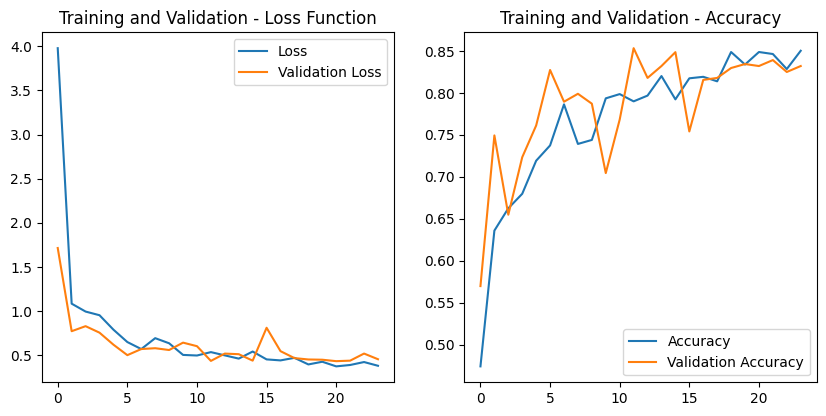

In [ ]:
# Graficos Train-Test Accuracy y Loss
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(model_hist['loss'], label='Loss')
plt.plot(model_hist['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(model_hist['accuracy'], label='Accuracy')
plt.plot(model_hist['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation - Accuracy')

#### **Matriz de Confusión**<br>

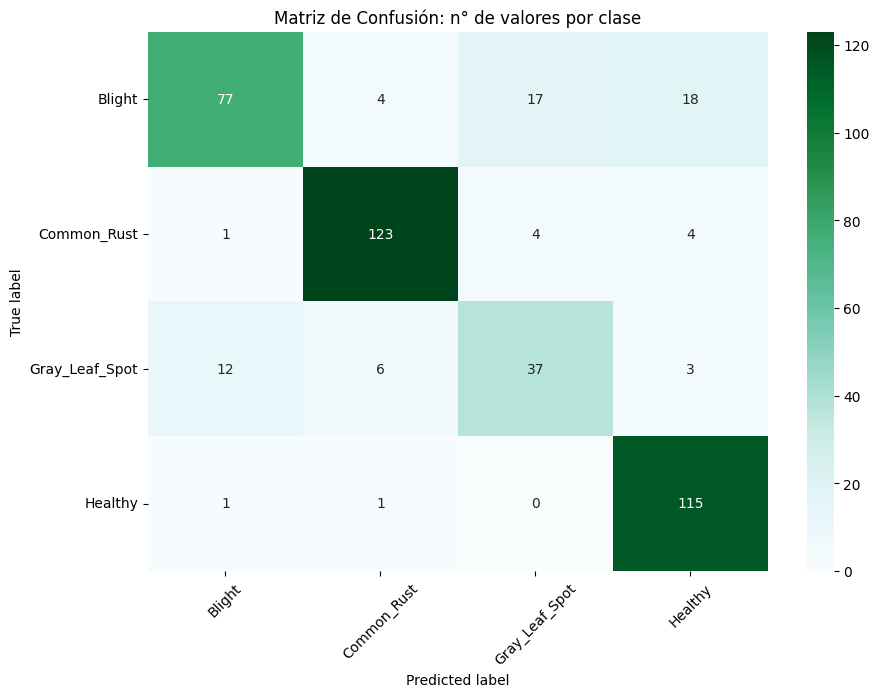

In [ ]:
# Generar la matriz de confusión
plot_confusion_matrix(y_test, y_pred,title='Matriz de Confusión: n° de valores por clase')

In [ ]:
# valores de la diagonal principal:
diagonal_sum = np.trace(confusion_matrix(y_test, y_pred))
print("Predicciones correctas: {}".format(diagonal_sum)) # suma de valores de la diagonal principal
print("Predicciones erroneas: {}".format(len(y_pred)-diagonal_sum)) # suma de valores fuera de la diagonal principaldiagonal_sum

Predicciones correctas: 352
Predicciones erroneas: 71


In [ ]:
# Crearemos una Matriz de Confusion con los % predichos para cada clase:
cm = confusion_matrix(y_test, y_pred) # creamos la Matriz de Confusion

# Calculamos los % de cada clase
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Redondear los valores a 1 decimal
cm_percent_rounded = np.round(cm_percent, 1)

# Convertir los valores redondeados a cadenas de caracteres
cm_percent_str = np.char.mod('%.1f', cm_percent_rounded)

# Agregamos el simbolo % a cada valor:
cm_porcentajes = np.char.add(cm_percent_str, '%')
cm_porcentajes

array([['66.4%', '3.4%', '14.7%', '15.5%'],
       ['0.8%', '93.2%', '3.0%', '3.0%'],
       ['20.7%', '10.3%', '63.8%', '5.2%'],
       ['0.9%', '0.9%', '0.0%', '98.3%']], dtype='<U5')

#### **ROC Curve**

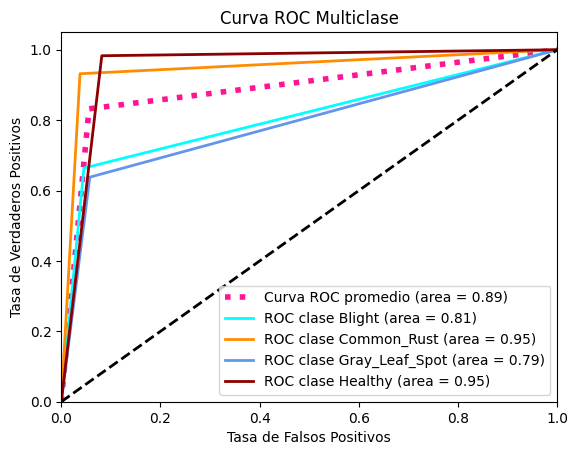

In [ ]:
plot_ROC_Curve(y_pred, y_test)

### **Guardado del Modelo**

In [ ]:
# Guardamos el modeloy el history en la carpeta 'models':
# Guardamos el modelo:
save_model(model,"/content/drive/MyDrive/Colab Notebooks/MAIZ/src/models/model_4.2_ResNet50.keras")

# Guardamos el historial en un archivo pkl:
with open('model_hist_4.2_ResNet50.pkl', 'wb') as file:
    pickle.dump(model_hist.history, file)

In [ ]:
# Cargamos el modelo
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MAIZ/src/models/model_4.2_ResNet50.keras")

# Cargamos el history
with open('model_hist_4.2_ResNet50.pkl', 'rb') as file:
    model_hist = pickle.load(file)


### **4. Conclusiones**

Modelo 4.2
* Red Neuronal utilizada: ***ResNet50***
* **Accuracy**: *83,22 %*


## **Version 3**

**Técnicas**: Aplicamos *Data Augmentation*<br>

**Cabeza personalizada**:
  - GlobalAveragePooling2D() layer
  - Flatten() layer
  - Dense layer: with 512 and relu activation function.
  - Dense layer: with 4 clases and softmax activation function.



### **1. Modelo**

In [ ]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

# Input explícito
input_shape = (224, 224, 3)
inputs = Input(shape=input_shape)

# Aplicamos data augmentation
x = data_augmentation(inputs)

# Modelo base
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=input_shape)

base_model.trainable = False  # Congelamos el modelo base

# Pasamos los datos por el modelo base
x = base_model(x)

# Añadimos las capas superiores
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(len(clases), activation='softmax')(x)

# Modelo final
model = Model(inputs, outputs)

In [ ]:
# Compilamos
model.compile(optimizer= 'adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### **2. Entrenamiento del Modelo**

In [ ]:
# Indicamos el Early-Stopping: patience indica que cuando se repite n veces que frene
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)
n_epochs = 10

model_hist = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        batch_size=32,
                        verbose=1,
                        epochs=n_epochs,
                        callbacks= callback)

Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 35s 221ms/step - accuracy: 0.3722 - loss: 14.5632 - val_accuracy: 0.6619 - val_loss: 0.7669
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 32s 176ms/step - accuracy: 0.6109 - loss: 1.0742 - val_accuracy: 0.7447 - val_loss: 0.6967
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 180ms/step - accuracy: 0.6461 - loss: 0.8819 - val_accuracy: 0.5957 - val_loss: 0.8045
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - accuracy: 0.6476 - loss: 0.9214 - val_accuracy: 0.7541 - val_loss: 0.6890
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 19s 178ms/step - accuracy: 0.6903 - loss: 0.7622 - val_accuracy: 0.7849 - val_loss: 0.5324
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - accuracy: 0.6898 - loss: 0.7751 - val_accuracy: 0.7139 - val_loss: 0.6053
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 174ms/step - accuracy: 0.7079 - loss: 0.7353 - val_accuracy: 0.6265 - val_loss: 0.8038
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 173ms/step - accuracy: 0.7035 - loss: 

### **3. Evaluación del Modelo**

#### **Accuracy - Loss**

In [ ]:
# Tupla con los valores: (val_loss, val_accuracy):
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest loss:', round(test_loss,4))
print('Test accuracy:', round(test_acc,4))

14/14 - 2s - 138ms/step - accuracy: 0.7139 - loss: 0.6053

Test loss: 0.6053
Test accuracy: 0.7139


****

## **Version 4**:
**Técnicas**: Sin Data Augmentation.<br>
Aumentamos en n° de epochs: 30

**Cabeza personalizada**:
  - GlobalAveragePooling2D() layer
  - Flatten() layer
  - Dense layer: with 512 and relu activation function.
  - Dense layer: with 4 clases and softmax activation function.



### **1. Modelo**

In [ ]:
model = Sequential()

# Arquitectura del Modelo Base:
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))

for layer in base_model.layers:
  layer.trainable=False

# Añadimos las capas ocultas y la final
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(len(clases), activation='softmax'))

In [ ]:
# Compilamos
model.compile(optimizer= 'adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### **2. Entrenamiento del Modelo**

In [ ]:
# Indicamos el Early-Stopping: patience indica que cuando se repite n veces que frene
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)
n_epochs = 30

model_hist = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        batch_size=32,
                        verbose=1,
                        epochs=n_epochs,
                        callbacks= callback)

Epoch 1/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 39s 253ms/step - accuracy: 0.3772 - loss: 1.3943 - val_accuracy: 0.4232 - val_loss: 1.2221
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.5259 - loss: 1.0891 - val_accuracy: 0.5910 - val_loss: 0.9458
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.5896 - loss: 0.9555 - val_accuracy: 0.6099 - val_loss: 0.9039
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 22s 110ms/step - accuracy: 0.6115 - loss: 0.8734 - val_accuracy: 0.6856 - val_loss: 0.8314
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - accuracy: 0.6322 - loss: 0.8434 - val_accuracy: 0.6998 - val_loss: 0.7591
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.6740 - loss: 0.7823 - val_accuracy: 0.6572 - val_loss: 0.7513
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.6259 - loss: 0.8283 - val_accuracy: 0.7305 - val_loss: 0.6985
Epoch 8/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.6786 - loss: 0.7489 

### **3. Evaluación del Modelo**

#### **Accuracy - Loss**

In [ ]:
# Tupla con los valores: (val_loss, val_accuracy):
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest loss:', round(test_loss,4))
print('Test accuracy:', round(test_acc,4))

14/14 - 1s - 84ms/step - accuracy: 0.7565 - loss: 0.5639

Test loss: 0.5639
Test accuracy: 0.7565
